# Autoencoders

In this notebook, I improve the performance of the Autoencoder example.



In [19]:
# First, let's download and inspect the data!
from sklearn.datasets import fetch_lfw_people
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
faces = fetch_lfw_people()

# 3D Array "faces.images" contains images as 2d arrays, stacked along dimension 0
n_examples, height, width = faces.images.shape

# 2D Array "design_matrix" encodes each image as a 1d numeric row, as is conventional in statistics
design_matrix = faces.images.reshape((n_examples, -1))

n_features = design_matrix.shape[1]

print(
    "Labeled Faces in the Wild Dataset: \n\
    Number of examples: {}\n\
    Number of features: {}\n\
    Image height: {}\n\
    Image width: {}".format(
        n_examples,
        n_features,   # per image
        height,
        width))

# Let's gather all the images corresponding to Arnold Scwarzenegger to use as examples

# Make a list (of length one!) of labels corresponding to Arnold
# Array "faces.target_names" tells us which numeric label (index) corresponds to which person name (value)
arnold_labels = np.where(faces.target_names == 'Arnold Schwarzenegger')

# Get indices of all images corresponding to this label
# Array "faces.target" tells us which image (index) corresponds to which numeric image labels (value)
arnold_pics = np.where(np.isin(faces.target, arnold_labels))[0]


Labeled Faces in the Wild Dataset: 
    Number of examples: 13233
    Number of features: 2914
    Image height: 62
    Image width: 47


## Neural Autoencoders

The default example uses ReLU activation functions and 64 points across the entire network. This achieves acceptable performance, but shows undesired artifacts caused by the ReLU cutoff point, which could be a major issue depending on the use case.

One possible improvement is the use of an alternative final activation function, TanH is well suited to the problem if we expect pixels to be unlikely to take extreme values, and will likely produce smoother images as well as being more flexible, unfortunately this will also be more expensive to train and run. Another alternative is a linear final activation which will also reduce the probablity of any pixel becoming pure black.

Another improvement could be using a smaller hidden layer, allowing for denser storage /  more efficient compression, though depending on the task the larger dimension could make information more easily extractable or lead to less loss of information.

In [35]:
# Use a nonlinear neural network
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
input_image = Input(shape=(n_features,))

''' Default approach '''
encoded = Dense(64, activation='relu')(input_image)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(n_features, activation='relu')(decoded)

autoencoder = Model(input_image, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(design_matrix, design_matrix,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=0)
# Compute neural reconstruction
reconstruction = autoencoder.predict(design_matrix[arnold_pics[1]].reshape(1, -1))


''' TanH final layer '''
encoded = Dense(64, activation='relu')(input_image)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(n_features, activation='tanh')(decoded)

autoencoder = Model(input_image, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(design_matrix, design_matrix,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=0)
# Compute neural reconstruction
reconstructionT = autoencoder.predict(design_matrix[arnold_pics[1]].reshape(1, -1))


''' Linear final layer '''
encoded = Dense(64, activation='relu')(input_image)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(n_features, activation='linear')(decoded)

autoencoder = Model(input_image, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(design_matrix, design_matrix,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=0)
# Compute neural reconstruction
reconstructionL = autoencoder.predict(design_matrix[arnold_pics[1]].reshape(1, -1))


''' Denser Compression '''
encoded = Dense(64, activation='relu')(input_image)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(n_features, activation='relu')(decoded)

autoencoder = Model(input_image, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(design_matrix, design_matrix,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=0)
# Compute neural reconstruction
reconstructionD = autoencoder.predict(design_matrix[arnold_pics[1]].reshape(1, -1))

''' Denser Compression with Butterfly '''
encoded = Dense(128, activation='relu')(input_image)
encoded = Dense(64, activation='relu')(input_image)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(n_features, activation='relu')(decoded)

autoencoder = Model(input_image, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(design_matrix, design_matrix,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=0)
# Compute neural reconstruction
reconstructionDB = autoencoder.predict(design_matrix[arnold_pics[1]].reshape(1, -1))

''' Butterfly + Linear '''
encoded = Dense(256, activation='relu')(input_image)
encoded = Dense(128, activation='relu')(input_image)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(n_features, activation='tanh')(decoded)

autoencoder = Model(input_image, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(design_matrix, design_matrix,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=0)
# Compute neural reconstruction
reconstructionB = autoencoder.predict(design_matrix[arnold_pics[1]].reshape(1, -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


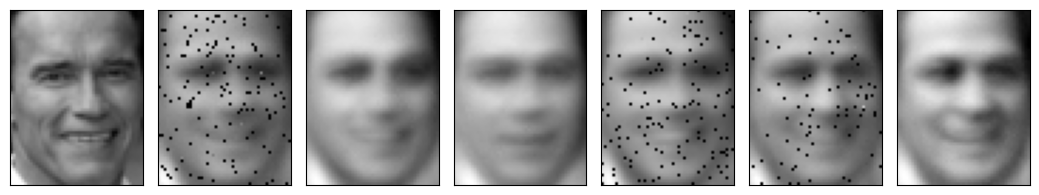

Image 0, No Loss: 0.0
Image 1, Original Approach: 2.525138995679299e-07
Image 2, TanH Final: 7.815955882506387e-08
Image 3, Linear Final: 9.79461560746131e-08
Image 4, Smaller Bottleneck: 2.2321846415707114e-07
Image 5, Smaller Bottleneck With Butterfly: 1.552250807890232e-07
Image 6, Linear With Butterfly: 6.579546862894858e-08


In [36]:
# Do visual comparison
plot_faces([design_matrix[arnold_pics[1]], reconstruction, reconstructionT, reconstructionL, reconstructionD, reconstructionDB, reconstructionB], n_row=1, n_col=7)

# Do numeric comparison
# We also normalize the black/white gradient to take values in [0,1] (divide by 255)
print(f"Image 0, No Loss: {np.mean(np.power((design_matrix[arnold_pics[1]].T - design_matrix[arnold_pics[1]].T) / 255, 2))}")
print(f"Image 1, Original Approach: {np.mean(np.power((design_matrix[arnold_pics[1]].T - reconstruction) / 255, 2))}")
print(f"Image 2, TanH Final: {np.mean(np.power((design_matrix[arnold_pics[1]].T - reconstructionT) / 255, 2))}")
print(f"Image 3, Linear Final: {np.mean(np.power((design_matrix[arnold_pics[1]].T - reconstructionL) / 255, 2))}")
print(f"Image 4, Smaller Bottleneck: {np.mean(np.power((design_matrix[arnold_pics[1]].T - reconstructionD) / 255, 2))}")
print(f"Image 5, Smaller Bottleneck With Butterfly: {np.mean(np.power((design_matrix[arnold_pics[1]].T - reconstructionDB) / 255, 2))}")
print(f"Image 6, Linear With Butterfly: {np.mean(np.power((design_matrix[arnold_pics[1]].T - reconstructionB) / 255, 2))}")